# Sentiment analysis with LSTM Deep Neural Networks

The following model aims to predict wether an amazon review is positive or negative. The product reviews are from the Electronics section.

First the required packages are imported.

In [1]:
import pandas as pd 
import numpy as np
import keras as ks
from matplotlib import pyplot
import gzip 
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

Using TensorFlow backend.


Next the data is loaded.

In [2]:
def parse(path): 
    g = gzip.open(path, 'rb') 
    for l in g: 
        yield eval(l) 
def getDF(path): 
    i = 0 
    df = {} 
    for d in parse(path): 
        df[i] = d 
        i += 1 
    return pd.DataFrame.from_dict(df, orient='index')
df = getDF('reviews_Electronics_5.json.gz')

We check the structure.

In [3]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3.0,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011"


The target variable will be based on the overall rating column, therefore, samples with that missing variable are excluded.

In [4]:
df = df[df['overall'].notnull()]

We are going to label as positive review those with rating above 3 and as negative those below 3.

In [5]:
df = df[df['overall']!=3.0]
df.loc[df['overall']>3.0, 'sent'] = 1
df.loc[df['overall']<3.0, 'sent'] = 0

Summary and reviewText are concatenated such that there is only one input for the model.

In [6]:
df['review'] = df['summary'] + '. ' + df['reviewText']

We check again the dataset.

In [7]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,sent,review
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5.0,Gotta have GPS!,1370131200,"06 2, 2013",1.0,Gotta have GPS!. We got this GPS for my husban...
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010",0.0,Very Disappointed. I'm a professional OTR truc...
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2.0,"Great grafics, POOR GPS",1290556800,"11 24, 2010",0.0,"Great grafics, POOR GPS. Not going to write a ..."
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1.0,"Major issues, only excuses for support",1317254400,"09 29, 2011",0.0,"Major issues, only excuses for support. I've h..."
5,A2JXAZZI9PHK9Z,0594451647,"Billy G. Noland ""Bill Noland""","[3, 3]",I am using this with a Nook HD+. It works as d...,5.0,HDMI Nook adapter cable,1388707200,"01 3, 2014",1.0,HDMI Nook adapter cable. I am using this with ...


In [8]:
df['review'].iloc[0]

'Gotta have GPS!. We got this GPS for my husband who is an (OTR) over the road trucker.  Very Impressed with the shipping time, it arrived a few days earlier than expected...  within a week of use however it started freezing up... could of just been a glitch in that unit.  Worked great when it worked!  Will work great for the normal person as well but does have the "trucker" option. (the big truck routes - tells you when a scale is coming up ect...)  Love the bigger screen, the ease of use, the ease of putting addresses into memory.  Nothing really bad to say about the unit with the exception of it freezing which is probably one in a million and that\'s just my luck.  I contacted the seller and within minutes of my email I received a email back with instructions for an exchange! VERY impressed all the way around!'

All the variables that are not of interest are dropped.

In [9]:
df = df[['review','sent']]

Next we split into train and test dataset at 80/20.

In [10]:
train, test = train_test_split(df, test_size=0.2)

Check what is the balance between postive and negative classes.

In [11]:
train.sent.value_counts()

1.0    1084984
0.0     152560
Name: sent, dtype: int64

We can see that this is and unbalanced dataset. As the computing resources are limited and the amount of data large enough, we are going to randomly drop a number of postive cases until the dataset is balanced. That will help with common class inbalance issues and help with the undestanding of accuracy measures.

In [12]:
# Class count
count_class_0 = (train['sent'] == 0).sum()
count_class_1 = (train['sent'] == 1).sum()

# Divide by class
df_class_0 = train[train['sent'] == 0]
df_class_1 = train[train['sent'] == 1]
df_class_1_under = df_class_1.sample(count_class_0)
train = pd.concat([df_class_1_under, df_class_0], axis=0)
print('Random under-sampling:')
print(train.sent.value_counts())

Random under-sampling:
0.0    152560
1.0    152560
Name: sent, dtype: int64


In [13]:
# Class count
count_class_0 = (test['sent'] == 0).sum()
count_class_1 = (test['sent'] == 1).sum()

# Divide by class
df_class_0 = test[test['sent'] == 0]
df_class_1 = test[test['sent'] == 1]
df_class_1_under = df_class_1.sample(count_class_0)
test = pd.concat([df_class_1_under, df_class_0], axis=0)
print('Random under-sampling:')
print(test.sent.value_counts())

Random under-sampling:
0.0    38304
1.0    38304
Name: sent, dtype: int64


### Text preprocessing

In [14]:
import re, string, unicodedata
import nltk
import contractions
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

First we expand the contractions.

In [15]:
train['review'] = train['review'].apply(contractions.fix)
test['review'] = test['review'].apply(contractions.fix)

Lets check it.

In [16]:
train['review'].iloc[0]

'Not easy to use many leys and touchpad, connection is good. Additional buttons to be pressed which are single / dedicated in normal keyboard. touch pad not comfortable including left / right click buttons. Connection is good - set it and forget.'

Looks good. Now we will tokenize the text

In [17]:
train['review'] = train['review'].apply(nltk.word_tokenize)
test['review'] = test['review'].apply(nltk.word_tokenize)

In [18]:
train['review'].iloc[0]

['Not',
 'easy',
 'to',
 'use',
 'many',
 'leys',
 'and',
 'touchpad',
 ',',
 'connection',
 'is',
 'good',
 '.',
 'Additional',
 'buttons',
 'to',
 'be',
 'pressed',
 'which',
 'are',
 'single',
 '/',
 'dedicated',
 'in',
 'normal',
 'keyboard',
 '.',
 'touch',
 'pad',
 'not',
 'comfortable',
 'including',
 'left',
 '/',
 'right',
 'click',
 'buttons',
 '.',
 'Connection',
 'is',
 'good',
 '-',
 'set',
 'it',
 'and',
 'forget',
 '.']

Next we are going to do a set of transformations.

In [21]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

train['review'] = train['review'].apply(normalize)
test['review'] = test['review'].apply(normalize)

Lets check the number of unique words.

In [22]:
len(train['review'].apply(pd.Series).stack().unique())

407534

And the number of words in each sample.

In [23]:
train['totalwords'] = train['review'].str.len().copy()
print("Mean %.2f words STD(%f)" % (np.mean(train['totalwords']), np.std(train['totalwords'])))

Mean 64.17 words STD(82.198017)


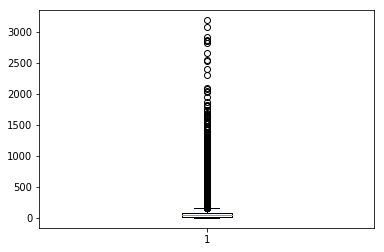

In [24]:
pyplot.boxplot(train['totalwords'])
pyplot.show()

We will drop the 10% most extreme samples in terms of number of words such that we have a better look at the number of words in each.

In [25]:
train = train[train['totalwords']>train['totalwords'].quantile(0.05)]
train = train[train['totalwords']<train['totalwords'].quantile(0.95)]

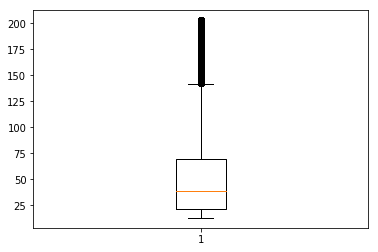

In [26]:
pyplot.boxplot(train['totalwords'])
pyplot.show()

Lets check if the dataset is still balanced.

In [27]:
print(train.sent.value_counts())

0.0    138626
1.0    136365
Name: sent, dtype: int64


Looks good! Lets finally resent the indexes.

In [28]:
train = train.sample(frac=1).reset_index(drop=True)
train.head()

,review,sent,totalwords
0,"[great, product, great, people, square, years,...",1.0,52
1,"[work, card, work, windows, 7, x64, machine, c...",0.0,71
2,"[oh, gosh, literally, crumbled, hand, got, use...",0.0,49
3,"[minty, deliciousness, made, macbook, look, go...",1.0,14
4,"[works, well, charger, works, daughter, kindle...",1.0,15


We are going to detokenize now such that we can take advantage of Keras tokenizer later.

In [29]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

train['review'] = train['review'].apply(TreebankWordDetokenizer().detokenize)
test['review'] = test['review'].apply(TreebankWordDetokenizer().detokenize)

We will tokenize now with Keras tokenizer and use the top 5000 most common words for word sequences.

In [30]:
# Create sequence
top_words = 5000
t = Tokenizer(num_words= top_words)
t.fit_on_texts(train['review'])

Pad dataset to a maximum review length in words.

In [31]:
max_words = 150
sequences_train = t.texts_to_sequences(train['review'])
X_train = ks.preprocessing.sequence.pad_sequences(sequences_train, maxlen=max_words)
sequences_test = t.texts_to_sequences(test['review'])
X_test = ks.preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_words)
print(X_train)

[[   0    0    0 ... 3618 2147  595]
 [   0    0    0 ...   51   29  515]
 [   0    0    0 ...   93    6    1]
 ...
 [   0    0    0 ...  559 1860  265]
 [   0    0    0 ...  461  462  409]
 [   0    0    0 ...  836   75  111]]


### Modelling

In [32]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import SpatialDropout1D
from keras.layers.embeddings import Embedding

Compile the LSTM neural network with dropout layers to avoid overfitting.

In [33]:
embedding_vector_length = 32 
model = Sequential() 
model.add(Embedding(top_words, 
                    embedding_vector_length, 
                    input_length=max_words)) 
model.add(Dropout(0.5))
model.add(LSTM(units=150,
               activation='tanh',
               recurrent_activation='hard_sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary()) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 32)           160000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               109800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 269,951
Trainable params: 269,951
Non-trainable params: 0
_________________________________________________________________
None

We have 269951 parameters to optimize.

In [ ]:
model.fit(X_train, 
          train.sent, 
          validation_data=(X_test, test.sent), 
          epochs=10, 
          batch_size=128,
          verbose=1)

Train on 274991 samples, validate on 76608 samples
Epoch 1/10
274991/274991 [==============================] - 2443s 9ms/step - loss: 0.2743 - acc: 0.8871 - val_loss: 0.2368 - val_acc: 0.9065
Epoch 2/10
274991/274991 [==============================] - 2082s 8ms/step - loss: 0.2199 - acc: 0.9128 - val_loss: 0.2191 - val_acc: 0.9132
Epoch 3/10
274991/274991 [==============================] - 2079s 8ms/step - loss: 0.2073 - acc: 0.9177 - val_loss: 0.2147 - val_acc: 0.9143
Epoch 4/10
274991/274991 [==============================] - 2093s 8ms/step - loss: 0.1994 - acc: 0.9204 - val_loss: 0.2092 - val_acc: 0.9158
Epoch 5/10
274991/274991 [==============================] - 2147s 8ms/step - loss: 0.1931 - acc: 0.9234 - val_loss: 0.2086 - val_acc: 0.9169
Epoch 6/10
274991/274991 [==============================] - 2155s 8ms/step - loss: 0.1877 - acc: 0.9256 - val_loss: 0.2066 - val_acc: 0.9172
Epoch 7/10
274991/274991 [==============================] - 2112s 8ms/step - loss: 0.1824 - acc: 0.9276

The models is trained and we have achieved a 92% accuracy in the validation dataset!

Data source citation:
Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering
R. He, J. McAuley
WWW, 2016